<p align=center>🤖Zoidberg 2.0📈</p>

---



# Mounting the dataset

The google collab environment isn't persistent, we therefore need to mount our drive (personal one, a shortcut to the shared-with-me folder containing the dataset needs to be created) to access the dataset.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
base_dir = "/content/drive/MyDrive/ZoidBerg2.0 - T-Dev-810/chest_Xray"

Mounted at /content/drive


Now that the dataset is accessible, we need to load its images that will be used to [train, validate and test](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) our algorithm.

# When to load

This could either be done
- at the start (pre-loading), allowing
  - to load everything at once faster through multiprocessing
  - to access images faster since we just need to read from the disk everytime it's needed
  - consistency on epochs as they'll use exactly the same data every time
  - a clear separated code flow
- everytime an image is needed (on-the-fly loading), permitting
  - real-time data augmentation, if the dataset is updated while the model is trained
  - memory efficiency, large datasets may not fit into the RAM if loaded all at once

Given the benefits differencial, one would choose the former. That's however if it wasn't for the fact that our dataset is 1.16GB of **compressed** images that will, once decompressed, weight in total more than what an usual 12-15GB CPU/GPU RAM can handle.

We therefore chose to opt for the later through a technique known as "batch processing", where the large initial data is split evenly into smaller "batches" of images that are decompressed/compressed in the RAM when needed.

# Dataset analysis

The next step is to analyse the provided dataset's folder architecture:

- train
  - PNEUMONIA
    - 3875 elements
  - NORMAL
    - 1341 elements
- val
  - PNEUMONIA
    - 8 elements
  - NORMAL
    - 8 elements
- test
  - PNEUMONIA
    - 390 elements
  - NORMAL
    - 234 elements

for a total of 5856 elements where elements are .jpeg images of various sizes ranging from 384 to 2916 in width and 127 to 2713 in height.

Additionally, the PNEUMONIA folders' images' names contain either "virus" or "bacteria", allowing us to load/use those separately for a more precise pneumonia diagnostic:
- train
  - bacteria 2530
  - virus 1345
- val
  - bacteria 8
  - virus 0
- test
  - bacteria 242
  - virus 148

We can note that there is significantly more images pneumonia originating from bacterias. This data imbalance could lead into the model being biased into leaning results more toward bacteria pneumonia by default.

In [ ]:
from PIL import Image
import os
import numpy as np

sets = ["train", "val", "test"]
types = ["PNEUMONIA", "NORMAL"]
images = {}
for set_name in sets:
    images[f"{set_name}_normal"] = []
    images[f"{set_name}_bacteria"] = []
    images[f"{set_name}_virus"] = []
total_images = 0
total_size = 0
lowest_width = float('inf')
highest_width = 0
lowest_height = float('inf')
highest_height = 0
lowest_pixels = float('inf')
highest_pixels = 0
total_width = 0
total_height = 0
total_pixel = 0
widths = []
heights = []
pixels = []

print(f"Loading images from {base_dir}")
for set_name in sets:
    for type_name in types:
        path = os.path.join(base_dir, set_name, type_name)
        for filename in os.listdir(path):
            if filename.endswith(".jpeg"):
                with Image.open(os.path.join(path, filename)) as image:
                    width, height = image.size
                    pixel = width * height
                    total_pixel += pixel
                    total_size += pixel * (1 if image.mode == "L" else 3)
                    lowest_width = min(lowest_width, width)
                    lowest_height = min(lowest_height, height)
                    lowest_pixels = min(lowest_pixels, pixel)
                    highest_width = max(highest_width, width)
                    highest_height = max(highest_height, height)
                    highest_pixels = max(highest_pixels, pixel)
                    total_width += width
                    total_height += height
                    widths.append(width)
                    heights.append(height)
                    pixels.append(pixel)
                    image.load()
                    if "bacteria" in filename:
                        images[f"{set_name}_bacteria"].append(image)
                    elif "virus" in filename:
                        images[f"{set_name}_virus"].append(image)
                    else:
                        images[f"{set_name}_normal"].append(image)

print(f"Loaded:")
for set_type in images:
    print(f"\t{set_type}: {len(images[set_type])}")
    total_images += len(images[set_type])
print(f"for a total of {total_images} images ({total_size} bytes)")
print(f"Lowest width: {lowest_width}")
print(f"Highest width: {highest_width}")
print(f"Average width: {round(total_width / total_images)}")
print(f"Median width: {round(np.median(widths))}")
print(f"Lowest height: {lowest_height}")
print(f"Highest height: {highest_height}")
print(f"Average height: {round(total_height / total_images)}")
print(f"Median height: {round(np.median(heights))}")
print(f"Lowest pixels: {lowest_pixels}")
print(f"Highest pixels: {highest_pixels}")
print(f"Average pixels: {round(total_pixel / total_images)}")
print(f"Median pixels: {round(np.median(pixels))}")

Loading images from /content/drive/MyDrive/ZoidBerg2.0 - T-Dev-810/chest_Xray
Loaded:
	train_normal: 1341
	train_bacteria: 2530
	train_virus: 1345
	val_normal: 8
	val_bacteria: 8
	val_virus: 0
	test_normal: 234
	test_bacteria: 242
	test_virus: 148
for a total of 5856 images (8505428617 bytes)
Lowest width: 384
Highest width: 2916
Average width: 1328
Median width: 1281
Lowest height: 127
Highest height: 2713
Average height: 971
Median height: 888
Lowest pixels: 48768
Highest pixels: 7532028
Average pixels: 1418909
Median pixels: 1136928


# Data augmentation

To fight this potential bias, a technique know as [data augmentation](https://en.wikipedia.org/wiki/Data_augmentation) can help with generating new data from existing data.

The benefits, among others, are:
- Enhanced model performance

  Data augmentation techniques help enrich datasets by creating many variations of existing data. This provides a larger dataset for training and enables a model to encounter more diverse features. The augmented data helps the model better generalize to unseen data and improve its overall performance in real-world environments.

- Reduced data dependency

  Data augmentation is a useful technology in medical imaging because it helps improve diagnostic models that detect, recognize, and diagnose diseases based on images. The creation of an augmented image provides more training data for models, especially for rare diseases that lack source data variations. The production and use of synthetic patient data advances medical research while respecting all data privacy considerations.

- Mitigate overfitting in training data

  Overfitting is the undesirable ML behavior where a model can accurately provide predictions for training data but it struggles with new data. In contrast, data augmentation provides a much larger and more comprehensive dataset for model training. It makes training sets appear unique to deep neural networks, preventing them from learning to work with only specific characteristics.

Data augmentation is a central technique in computer vision tasks. It helps create diverse data representations and tackle class imbalances in a training dataset.

The first usage of augmentation in computer vision is through position augmentation. This strategy crops, flips, or rotates an input image to create augmented images. Cropping either resizes the image or crops a small part of the original image to create a new one. Rotation, flip, and resizing transformation all alter the original randomly with a given probability of providing new images.

Another usage of augmentation in computer vision is in color augmentation. This strategy adjusts the elementary factors of a training image, such as its brightness, contrast degree, or saturation. These common image transformations change the hue, dark and light balance, and separation between an image's darkest and lightest areas to create augmented images.

<img src='https://miro.medium.com/v2/resize:fit:850/1*ae1tW5ngf1zhPRyh7aaM1Q.png'>


# Image processing libraries

The following task, since there is so many images to load, is deciding which python image processing library to pick for the fastest loading.

[This article](https://learnopencv.com/efficient-image-loading/) details benchmarking code to compare the 2 most popular image processing libraries in python (Pillow and OpenCV), one of their optimization fork (Pillow-SIMD) and a fourth optimized jpeg-specialized one (TurboJPEG).

As we can see from its results, TurboJPEG is the most efficient library and is specialized in the .jpeg format which we use, making it the perfect choice.

<img src='https://learnopencv.com/wp-content/uploads/2020/06/mean-median-rgb.png'>

The performance differences are however negligible in the face of GPU acceleration, which TurboJPEG does not natively support in contrary to OpenCV, Tensorflow or Nvidia's DALI.

# K-Nearest Neighbors

[K-Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) (KNN) is a simple, instance-based [machine learning](https://en.wikipedia.org/wiki/Machine_learning) algorithm used for classification and regression.

It works by finding the 'k' closest training examples to a given test example and predicting the label based on the majority class among those neighbors.

Why KNN Might Be a Good Choice for Medical Image Classification:
- Simplicity: KNN is easy to understand and implement.
- Non-parametric: It makes no assumptions about the underlying data distribution, which is useful for medical images that might not follow standard distributions.
- Adaptability: It can handle multi-class problems and can be adapted to different types of distance metrics to measure similarity between images.

Drawbacks of Using KNN for Medical Image Classification:
- Computational Cost: KNN can be slow with large datasets, as it requires computing the distance between the test instance and all training instances.
- Memory Intensive: It requires storing all the training data, which can be problematic for large datasets like medical images.
- Curse of Dimensionality: Performance can degrade with high-dimensional data, which is common in image analysis.
- Lack of Interpretability: KNN does not provide insights into which features are important for the classification, making it less interpretable than some other models.

Overall, while KNN can be a straightforward and flexible choice, its computational inefficiency and potential issues with high-dimensional data make it less suitable for large-scale medical image classification tasks compared to more advanced techniques like convolutional neural networks.

<img src='https://miro.medium.com/v2/resize:fit:1316/1*n9v1xsBi0bek98rqBnWGEg.gif'>

# Convolutional Neural Networks

[Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) are a class of [deep learning](https://en.wikipedia.org/wiki/Deep_learning) algorithms that are particularly effective for image analysis tasks, making them ideal for pneumonia recognition in radiographic images:

- Feature Learning: Traditional image processing techniques require manual extraction of features. CNNs can automatically learn and extract features from images, which is beneficial in medical imaging where defining what constitutes a feature can be complex.

- Hierarchical Pattern Recognition: CNNs work by recognizing patterns in a hierarchical manner. Lower layers may recognize simple features like edges and lines, while deeper layers combine these simple features to recognize more complex structures. This is particularly useful in pneumonia detection where the disease can manifest as a variety of patterns in the lungs.

- Translation Invariance: Once a CNN learns a feature, it can recognize that feature anywhere in the image. This is crucial in pneumonia detection as the infection can occur in different parts of the lungs.

- Robustness to Noise and Variations: Medical images can often contain noise and can vary due to different imaging conditions. CNNs are robust to such variations and can still perform well.

- End-to-End Training: With CNNs, the entire model is trained in an end-to-end fashion. This means that the raw pixel values of the image are input to the model, and the model learns to extract features and make predictions all by itself. This eliminates the need for manual feature extraction or selection.

- Performance: CNNs have been proven to perform exceptionally well on image classification tasks. They have achieved state-of-the-art results in many medical imaging tasks, including pneumonia detection.

<img src='https://miro.medium.com/v2/resize:fit:1400/1*Fw-ehcNBR9byHtho-Rxbtw.gif'>




# Handling images of different sizes

As mentionned before, the dataset is made of images with greatly various sizes. As we can see from [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8700246/), it will have an impact on the CNN performance. Which is why we need to correctly [handle this problem](https://wandb.ai/ayush-thakur/dl-question-bank/reports/How-to-Handle-Images-of-Different-Sizes-in-a-Convolutional-Neural-Network--VmlldzoyMDk3NzQ) (note that the following methods aren't considered for anything else than having a CNN work in the first place, data augmentation could be employed only after that):

## Resizing


Resizing images to a common single size is a popular approach in processing data for medical imagery CNNs due to several key reasons.

Firstly, standardizing image dimensions ensures uniformity in input data, facilitating the training process and improving model performance by reducing variations in feature representation.

Secondly, it streamlines computational complexity, as fixed-size inputs simplify the architecture design and optimize memory usage during training and inference.

Multiple papers have extensively researched on [The effect of image resizing on CNN performance](https://isprs-archives.copernicus.org/articles/XLVI-4-W5-2021/501/2021/isprs-archives-XLVI-4-W5-2021-501-2021.pdf/), clearly depicted here![picture](https://drive.google.com/uc?id=1Ln8OffmMfiqgbP5NUmSXOxJGGL9DHDYf)

which makes [Learning to Resize Images for Computer Vision Tasks](https://arxiv.org/pdf/2103.09950.pdf) important.

In the case of our dataset, the pixels corresponding to a potential small pneumonia could disappear during a downsize or pixels corresponding to a bone/the lung/noise could be distorded during an upsize resulting in the CNN giving out false negatives or positives.

The amount of noise present on some images ("R" at the top left and little white lines on the sides for all images as well as some having the hour or some other medical informations text at the corners) could also be amplified by an upsize making it more difficult for the CNN to identify key features.

In conclusion, while resizing remains a popular and valuable preprocessing step for handling datasets of images of various sizes/ratios, its implementation must be approached with care and consideration for its potential impact on diagnostic accuracy in the case of medical images.

## Cropping

Similar to resizing, cropping facilitates the standardization of input size for CNNs. By cropping images to a consistent size, variations in input dimensions are minimized, which simplifies the training process and improves model performance.

One of the primary advantages of cropping is the ability to extract specific regions of interest within an image. By eliminating extraneous information (such as the previous ones I've mentionned), cropping enables a more focused and efficient analysis process.

However, as the images are of different sizes, ratios and focus (not all of them are centered on the backbone and some patients were a bit tilted), efficient constant cropping might prove difficult to the point where a dynamic CNN approach could be considered but would add an unnecesarry layer of difficulty.

<img src='https://aitorshuffle.github.io/images/picon_crop_2019_fig4_abstract.png'>


## Inherent Network Property

[Fully Convolutional Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf) (FCNs) are a type of neural network architecture specifically designed for semantic segmentation tasks, where the goal is to label each pixel in an image with a corresponding class label (for example: pneumonia pixels).

<img src='https://production-media.paperswithcode.com/methods/new_alex-model.jpg'>

Let's break down the key components and concepts associated with FCNs:

- Convolutional Layers:

  FCNs primarily consist of convolutional layers, which are responsible for learning hierarchical features from the input image. These layers apply convolution operations to the input image, extracting features at different spatial resolutions.
- Pooling Layers:

  Pooling layers are used in FCNs for downsampling the feature maps, reducing their spatial dimensions while retaining important features. Common pooling operations include **max pooling and average pooling**.
- Upsampling Layers:

  Upsampling layers are used to increase the spatial dimensions of the feature maps. This helps in recovering the spatial information lost during downsampling and enables the network to produce segmentation maps with the same resolution as the input image.
- Avoidance of Dense Layers:

  Unlike traditional neural network architectures, FCNs avoid using dense (fully connected) layers. Dense layers would require a fixed-size input, which is not suitable for segmentation tasks where the input image can have varying dimensions. By using only convolutional and upsampling layers, FCNs can handle images of different sizes efficiently.
- Locally Connected Layers:

  FCNs only use locally connected layers, meaning each output feature depends only on a small region of the input image. This property allows FCNs to **handle images of different sizes without the need for resizing or cropping**.
- Downsampling Path and Upsampling Path:

  FCNs are typically structured with a downsampling path and an upsampling path. The downsampling path, often composed of convolutional and pooling layers, captures the context and global information of the input image. The upsampling path, composed of upsampling and convolutional layers, helps in localizing objects by gradually increasing the spatial resolution of the feature maps.
- Skip Connections:

  Skip connections are connections between layers at the same spatial resolution in the downsampling and upsampling paths. These connections help preserve fine details and spatial information that may be lost during downsampling. By combining features from different resolutions, skip connections improve the segmentation accuracy of FCNs.

In summary, FCNs are tailored for semantic segmentation tasks, leveraging convolutional layers, pooling, and upsampling while avoiding dense layers. Their locally connected design and use of skip connections enable them to handle images of varying sizes and capture fine details necessary for accurate pixel-wise labeling.

[Global Average Pooling (GAP) and Global Max Pooling (GMP)](https://blog.paperspace.com/global-pooling-in-convolutional-neural-networks/) are fundamental techniques within convolutional neural networks (CNNs), frequently employed for feature extraction and dimensionality reduction, notably in image classification tasks.

<img src='https://you359.github.io/images/contents/cam_gap.png'>

GAP calculates the average activation across each feature map, effectively condensing spatial information into a single value per map. Conversely, GMP selects the maximum activation within each feature map, discarding the rest. These operations serve to reduce the spatial dimensions of the feature maps, facilitating subsequent processing.

What makes GAP and GMP particularly advantageous is their flexibility in handling datasets comprising images of varying sizes. Unlike fully connected layers that require fixed input dimensions, GAP and GMP operate independently of image size. This means CNN architectures employing these pooling techniques can seamlessly process images of different resolutions without the need for resizing or cropping, enhancing their adaptability to diverse datasets.

Moreover, both GAP and GMP play a pivotal role in enhancing computational efficiency. By condensing feature maps into single values, they significantly reduce the number of parameters in the network, leading to faster training and inference times. Additionally, this reduction in dimensionality helps mitigate overfitting, promoting generalization performance.

In summary, GAP and GMP offer a robust solution for feature extraction and dimensionality reduction in CNNs, especially in the context of image classification tasks. Their ability to handle images of varying sizes and enhance computational efficiency makes them indispensable components of modern CNN architectures.

# Data formats

So far we've only analysed the data itself and the provided folder architecture, but what about the nature itself of the dataset being reading directly from files ? Isn't there is machine learning dataset format specialized in reading more data more efficiently ?

There is, and according to this elaborate [article](https://servicedesk.surf.nl/wiki/display/WIKI/Best+Practice+for+Data+Formats+in+Deep+Learning),
<img src='https://servicedesk.surf.nl/wiki/download/attachments/56295498/benchmark_ImageNet10k_results.png?version=2&modificationDate=1677235283181&api=v2'>

HDF5 format would be the best choice for us as it's made of "intuitive array-based data like images" that isn't large enough (< 100GB) to justify LMDB.

We'll be ignoring Petastorm because of its complexity, TFRecords because it's not generalized for native use with Pytorch, ZIP/TAR because it would add an extra layer of uncompressing and we aren't necessarily concerned by disk space with google drive.

The final options are leaving the jpeg dataset as-is since, given the size of the initial dataset, the loading time is negligible or use HDF5 once the rest of the code is done to see if it makes a difference.

# KNN-CNN comparison

Comparing K-Nearest Neighbors (KNN) and Convolutional Neural Networks (CNN) is important for pneumonia classification because each algorithm offers unique strengths and weaknesses.\
KNN is simple and interpretable, making it useful for smaller datasets and quick prototyping. However, it may struggle with high-dimensional data and complex patterns.\
CNNs, on the other hand, excel at handling large image datasets and capturing intricate features, thanks to their deep learning capabilities.\
Evaluating both methods helps determine the most effective approach for accurate pneumonia detection, ensuring better patient outcomes through reliable diagnosis.

## Results with KNN

After evaluating multiple k-values, we identified the optimal k for our KNN, which yielded the best performance in classifying pneumonia.

Accuracy: 73.82%\
Classification Report:

|           | precision | recall | f1-score | support |
|-----------|-----------|--------|----------|---------|
| 0         | 0.86      | 0.53   | 0.66     | 233     |
| 1         | 0.68      | 0.92   | 0.79     | 233     |
|           |           |        |          |         |
| accuracy  |           |        | 0.74     | 466     |
| macro avg | 0.77      | 0.73   | 0.72     | 466     |
| weighted avg | 0.77   | 0.74   | 0.73     | 466     |

![picture](https://drive.google.com/uc?id=13X14OFZt6ljPleX1xHhwI6lwsPaMtK2Q)
![picture](https://drive.google.com/uc?id=11659omQmKtQWPQNd3waasQ7NqGYOleeH)

The KNN achieved an accuracy of 73.82% in classifying pneumonia from chest X-ray images. Accuracy measures how often the model correctly predicts both pneumonia and normal cases.\
In the classification report, recall (sensitivity) for pneumonia is high at 0.92, meaning it correctly identifies 92% of actual pneumonia cases, while its precision (positive predictive value) of 0.68 indicates 32% of predicted pneumonia cases were incorrect.\
Conversely, the model's precision for normal cases is higher at 0.87, but its recall is lower at 0.56, missing 44% of actual normal cases.\
The F1-scores balance these metrics, yielding 0.78 for pneumonia and 0.68 for normal cases.

The confusion matrix shows 19 false negatives (pneumonia cases predicted as normal) and 103 false positives (normal cases predicted as pneumonia) out of 233 instances in each class. This illustrates where the model misclassifies cases, impacting both sensitivity and specificity.

The ROC AUC score of 0.738 evaluates the model's ability to distinguish between pneumonia and normal cases, with a score closer to 1 indicating better performance.

Exploring CNNs could potentially enhance classification accuracy further. CNNs are adept at learning hierarchical representations of image data, capturing intricate features like textures and shapes that may improve pneumonia detection from X-ray images. Their deep learning capabilities could address limitations seen in KNN, particularly in handling high-dimensional data and extracting meaningful patterns, thereby potentially improving overall diagnostic performance.

## Results with CNN (Pytorch)

CNNs could potentially address KNN's limitations by autonomously learning hierarchical representations of image data, allowing for more accurate and nuanced pneumonia classification from chest X-ray images.

Accuracy: 73.74%\
Classification Report:

|           | precision | recall | f1-score | support |
|-----------|-----------|--------|----------|---------|
| 0         | 0.87      | 0.56   | 0.68     | 233     |
| 1         | 0.68      | 0.92   | 0.78     | 233     |
|           |           |        |          |         |
| accuracy  |           |        | 0.74     | 466     |
| macro avg | 0.77      | 0.74   | 0.73     | 466     |
| weighted avg | 0.77   | 0.74   | 0.73     | 466     | **texte en gras**

![picture](https://drive.google.com/uc?id=1EXS1IDs4oD40fSol50zTIQ2VdnTPOFpA)
![picture](https://drive.google.com/uc?id=1GEwCaSn5H1WuvieCauEvar812eyHhyQ3)

The CNN  achieved an accuracy of 73.74% in classifying pneumonia from chest X-ray images.

Comparing KNN and CNN for pneumonia classification reveals distinct advantages and limitations.

KNN, with its simplicity and high recall for pneumonia, is effective for smaller datasets and rapid prototyping. However, it struggles with high-dimensional data and exhibits lower precision for pneumonia cases.

CNN, while slightly lower in overall accuracy, excels in feature extraction and handles complex patterns better, offering a balanced performance with improved precision for pneumonia cases. CNN holds greater potential for enhancing diagnostic accuracy in pneumonia detection from chest X-ray images, addressing the limitations of KNN.

## Results with CNN (Tensorflow)

Our new convolutional neural network (CNN) implemented with PyTorch has yielded impressive results, achieving an overall accuracy of 96%.
Specifically, it has demonstrated a precision of 0.92 and recall of 0.97 for the NORMAL class, and a precision of 0.99 and recall of 0.96 for the PNEUMONIA class, resulting in a balanced and high-performing model across both categories.

This is reflected in a macro average F1-score of 0.96 and a weighted average F1-score of 0.97.

The training process was efficient, evidenced by a low train loss of 0.029 and a high train accuracy of 98.92%, with validation and test accuracies at 95.59% and 96.55%, respectively, indicating strong generalization capabilities.

Compared to our previous CNN built with TensorFlow, which only achieved a 73% accuracy, the significant improvement in performance is not attributed to the choice of deep learning library—both PyTorch and TensorFlow are robust and capable.

Instead, the superior results stem from enhancements in the CNN architecture and the quality of the training data, which have collectively contributed to the enhanced predictive power and reliability of the model.

Accuracy: 96%




|           | precision | recall | f1-score | support |
|-----------|-----------|--------|----------|---------|
| NORMAL    | 0.92      | 0.97   | 0.94     | 156     |
| PNEUMONIA | 0.99      | 0.96   | 0.98     | 366     |
|           |           |        |          |         |
| accuracy  |           |        | 0.97     | 522     |
| macro avg | 0.95      | 0.97   | 0.96     | 522     |
| weight-avg| 0.97      | 0.97   | 0.97     | 522     |


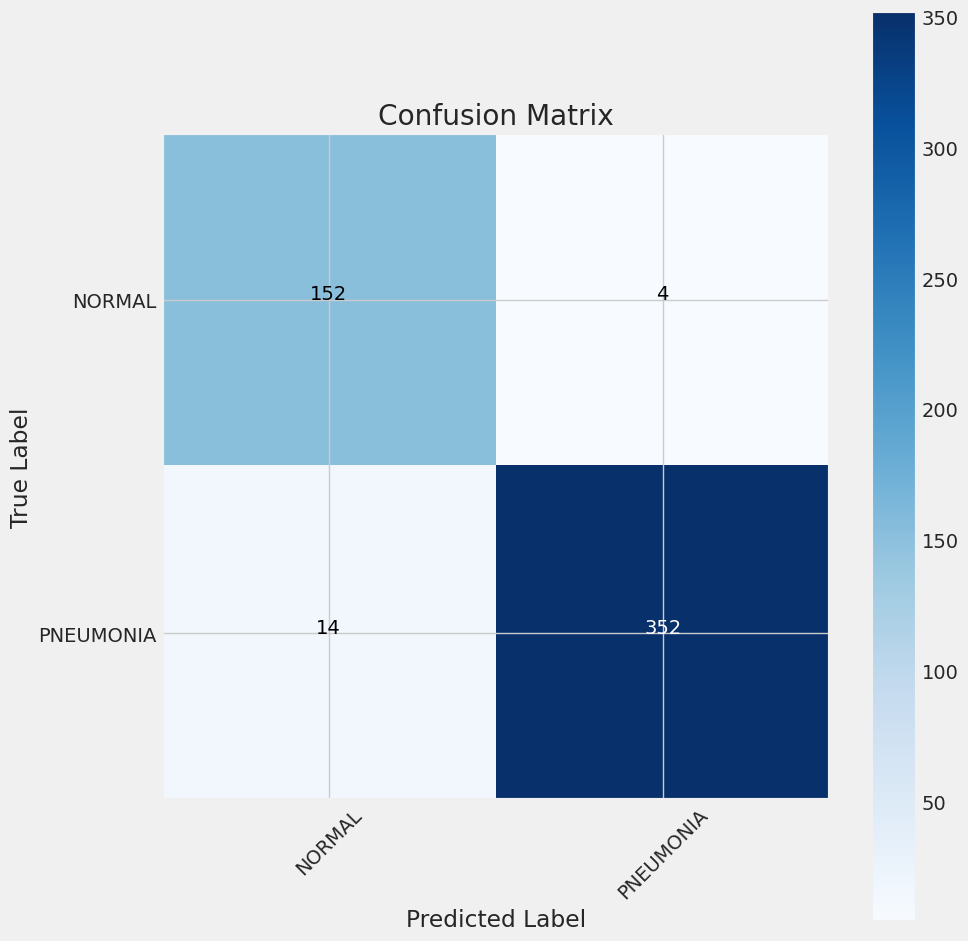

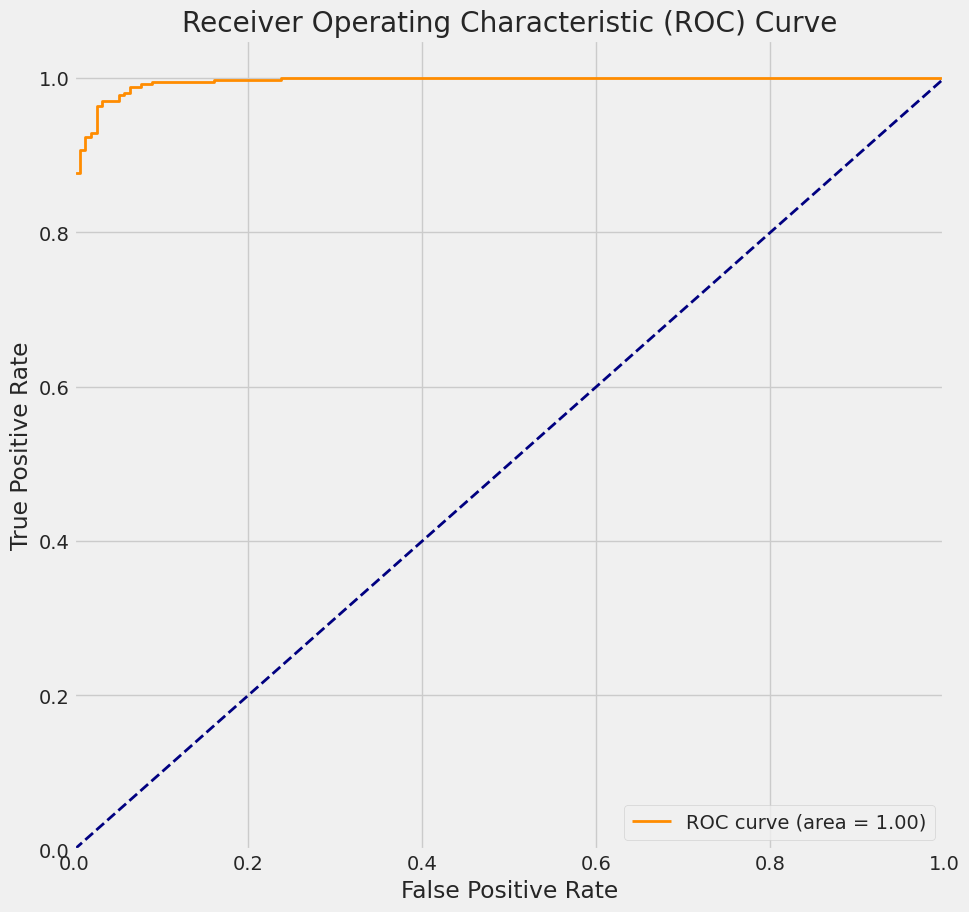

# Conclusion

These results underscore the efficacy of artificial intelligence, particularly convolutional neural networks (CNNs), in detecting pneumonia from medical X-ray images.

The CNN's ability to automatically and accurately identify complex patterns in visual data makes it particularly well-suited for medical image analysis.

Our PyTorch-based CNN achieved a high accuracy of 96%, significantly outperforming our previous TensorFlow implementation and demonstrating substantial gains over traditional machine learning methods like k-nearest neighbors (KNN).

While KNN relies heavily on feature engineering and can struggle with high-dimensional data, CNNs excel by directly learning from raw image data through hierarchical feature extraction.

This capability allows CNNs to capture intricate details in X-ray images that are crucial for accurate pneumonia diagnosis, leading to superior performance and reliability in clinical settings.

The advancements in CNN architectures and training techniques underscore the potential of AI to revolutionize medical diagnostics, providing faster, more accurate, and scalable solutions for detecting diseases like pneumonia.